In [1]:
# SIMULATION
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import list_initial_conditions as ic
import list_ibvp_solution as ibvp
import list_swwe_function as swe
from time import time
from flowtype import flowtype_function

start=time()
# ------------------------------
# set up nature of the simulation, with or without manufactured solution:
# 1. manufactured_solution = ibvp.linearSWWE_mms
# 2. manufactured_solution = False
mms = False

# to-do: manufactured solution need to be check with H and U value. 
# Check whether it carry perturbation or actual q value


# ------------------------------
RHS_linear = swe.linearswwe_RHS      
RHS_nonlinear = swe.nonlinear_swwe_RHS

# set up the SAT function
SAT_function = swe.linearised_SWWE_SAT_terms
# SAT_function = swe.SWE_SAT_terms_no_SAT

# ------------------------------
# set 'generated_wave = False' if manufactured_solution is not False
# 'generated_wave' is the incoming flux from the left boundary
# generated_wave = False
# generated_wave = ibvp.zero_wave
# generated_wave = ibvp.gaussian_wave_1
# generated_wave = ibvp.step_function_wave


# ------------------------------
# set up parameters
cfl = 0.25
H = 1.0
g = 9.81
c = np.sqrt(g*H)

# coefficient may vary 
U_coeff = 0
alpha_coeff = 0.0                      

U       = U_coeff*c
alpha   = alpha_coeff*(np.abs(U)+c)       # alpha here is  used as a coefficient for the linear part

flowtype = flowtype_function(U,c)

# ------------------------------
# set up the domain 
x0, xN = 0,(np.abs(U)+np.sqrt(g*H))*5
# x0, xN = 0, 4
N = 2**8
dx = (xN-x0)/(N-1)  
x = np.linspace(x0,xN,N)

# ------------------------------
# set up time parameters
dt = cfl*dx/(np.abs(U) + np.sqrt(g*H))      # (cfl * dx)/max speed
# sim_time = np.pi*2
timesteps = 1000
sim_time = timesteps*dt

# set up supportive matrix 
Q, A, P_inv, I_N = swe.linearised_SWWE_matrix_supportive(N, dx)

# list constants
constants_nonlinear = x,H,0,g,c,alpha,flowtype,Q,A,P_inv,I_N, \
        RHS_nonlinear, SAT_function, \
        False, generated_wave 

# x,H,U,g,c,alpha,flowtype,Q,A,P_inv,RHS_function, SAT,manufactured_solution, analytical_solution = constants

# solving the IBVP 
# set up initial conditions
# initial_type (int): The type of initial condition for perturbation height if no MMS. 
#                                0 = flat, 
#                                1 = Gaussian + constant H
#                                2 = Gaussian for perturbation, 
#                                4 = dam break with almost dry bed
#                                5 = dam break with almost dry bed and perturbation     
#                                6 = custom step function (with height=H)
#                                8 = flat (with height=H)

q_numerical_nonconservative      = ic.initial_condition(x, H, U, initial_height_type=1)
q_numerical_nonconservative_copy = ic.initial_condition(x, H, U, initial_height_type=1)



q = np.zeros_like(q_numerical_nonconservative_copy)
q[0] = q_numerical_nonconservative_copy[0]
q[1] = q_numerical_nonconservative_copy[0]*q_numerical_nonconservative_copy[1]


q_numerical_conservative = copy(q)
# q_analytical = copy(q)


# the loop for solving the IBVP

# print("linear")
# q_numerical_linear = swe.numerical_solution_linear(q_numerical_nonconservative,sim_time,dt,constants_linear)

print("non linear")
q_numerical_nonlinear = swe.numerical_solution_nonlinear(q_numerical_conservative,sim_time,dt,constants_nonlinear)

# q_analytical = swe.analytical_solution(x,sim_time,dt,constants)

end = time()
print(f"grid size: {N}, dx: {dx}")
print(f"simulation time: {np.round(sim_time,4)} s, dt: {np.round(dt,4)} s")
print(f"U*sqrt(gH): {U_coeff}")
print(f"U: {U}")
print(f"dissipation for linear case: alpha =  {alpha}")
print(f"for non linear dissipation calculate locally alpha = abs(u)+sqrt(gH)")
print(f"flowtype: {flowtype}")
print() 
print("Time taken: ", end-start)
 

linear
non linear
grid size: 256, dx: 0.06141356769947382
simulation time: 4.902 s, dt: 0.0049 s
U*sqrt(gH): 0
U: 0.0
dissipation for linear case: alpha =  0.0
for non linear dissipation calculate locally alpha = abs(u)+sqrt(gH)
flowtype: subcritical

Time taken:  3.0403800010681152


In [2]:
alpha

0.0

In [3]:
print(np.shape(ic.initial_condition(x, H, U, initial_height_type=8)))
print(np.shape(q_numerical_nonlinear))
print(np.shape(q_numerical_linear))

(2, 256)
(1002, 2, 256)
(1002, 2, 256)


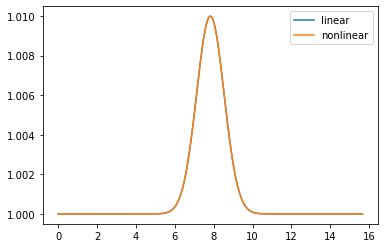

9.163671237039547e-06
6.42715884846146e-05
5.5111013315775675e-05


In [4]:
# initial condition 
# plt.plot(x,q_numerical_nonconservative[0])
plt.plot(x,q_numerical_linear[0][0],label="linear")
plt.plot(x,q_numerical_nonlinear[0][0],label="nonlinear")
plt.legend()
plt.show()

print(np.linalg.norm(q_numerical_nonconservative[0]-q_numerical_linear[0][0]))
print(np.linalg.norm(q_numerical_nonconservative[0]-q_numerical_nonlinear[0][0]))
print(np.linalg.norm(q_numerical_linear[0][0]-q_numerical_nonlinear[0][0]))

In [5]:
frame = 450

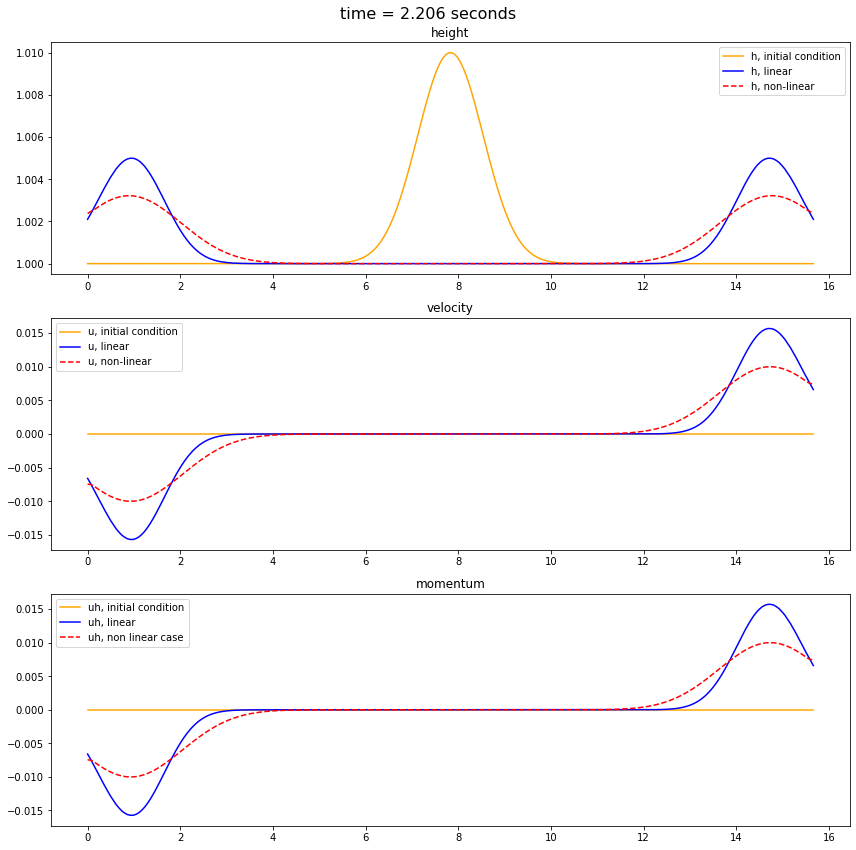

In [6]:
fig, axs = plt.subplots(3,1, figsize=(12,12))

# PLOT
if frame <= timesteps:
    h1_lin, u1_lin = q_numerical_linear[frame]
    h1_nn, uh1_nn = q_numerical_nonlinear[frame]

    u1_nn = uh1_nn/h1_nn

    axs[0].plot(x,q_numerical_nonconservative[0],label="h, initial condition", color = "orange")
    axs[0].plot(x,h1_lin, label='h, linear', color="blue")
    axs[0].plot(x,h1_nn, '--r', label='h, non-linear')
    # axs[0].plot(x,hobs, label='h, analytical', color="green")
    # axs[0].plot(x,h[1, :], label='h, torro', color="purple")
    axs[0].set_title("height")
    axs[0].legend()


    axs[1].plot(x,q_numerical_nonconservative[1], label='u, initial condition', color="orange")
    axs[1].plot(x,u1_lin, label='u, linear', color="blue")
    # axs[1].plot(x,u1_nn, label='u, non-linear', color="red")
    axs[1].plot(x,u1_nn, '--r', label='u, non-linear')
    # axs[1].plot(x,uobs, label='u, analytical', color="green")
    # axs[1].plot(x,u[1, :], label='u, torro', color="purple")
    axs[1].set_title("velocity")
    axs[1].legend()


    axs[2].plot(x,q_numerical_nonconservative[0]*q_numerical_nonconservative[1],label="uh, initial condition", color = "orange")
    axs[2].plot(x,h1_lin*u1_lin, label='uh, linear', color="blue")
    # axs[2].plot(x,q_numerical_nonlinear[frame][1], label='uh, non linear case', color="red")
    axs[2].plot(x,q_numerical_nonlinear[frame][1], '--r', label='uh, non linear case')
    # axs[2].plot(x,uobs*hobs, label='uh, analytical', color="green")
    # axs[2].plot(x,u[1, :]*h[1, :], label='uh, torro', color="purple")
    axs[2].legend()
    axs[2].set_title("momentum")

    fig.suptitle('time = %r seconds'  % np.round(frame*dt,3), fontsize=16)
    fig.tight_layout()
    
    plt.show()  

In [7]:
np.shape(q_numerical_linear)

(1002, 2, 256)

Volume check (h*dx)
initial volume: 15.739597869574354
error volume non-linear: 0.0035228453598961096


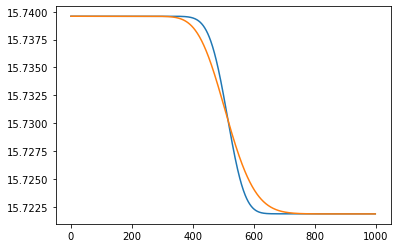

In [8]:
# VOLUME CHECK 
print("Volume check (h*dx)")
h0 = q_numerical_nonconservative[0]
h0_nn = q_numerical_conservative[0]

h1 = q_numerical_linear[frame][0]
h1_nn = q_numerical_nonlinear[frame][0]

volume_initial = np.sum(h0*dx)
volume_initial_nn = np.sum(h0_nn*dx)
volume_linear = np.sum(h1*dx)
volume_nn = np.sum(h1_nn*dx)

print(f"initial volume: {volume_initial}")
print(f"error volume non-linear: {(volume_initial_nn - volume_nn)}")

timesteps_ =   timesteps
volume_check_linear = np.zeros(timesteps_)
volume_check_nonlinear = np.zeros(timesteps_)

for i in range(timesteps_):

    h1 = q_numerical_linear[i][0]
    h1_nn = q_numerical_nonlinear[i][0]

    volume_check_linear[i] = np.sum(h1*dx)
    volume_check_nonlinear[i] = np.sum(h1_nn*dx)

plt.plot(np.arange(timesteps_),volume_check_linear, label="linear")
plt.plot(np.arange(timesteps_),volume_check_nonlinear, label="non-linear")
plt.show()

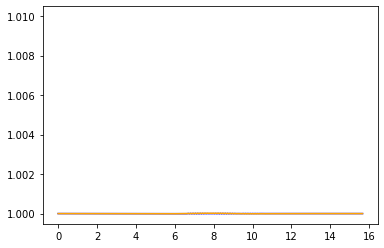

In [9]:
# Animation
from celluloid import Camera
fig = plt.figure()
camera = Camera(fig)



# fig, ax = plt.subplots(2,figsize=(10,10))
                       
for frame in range(timesteps):
    if frame % 20 == 0:
        # PLOT
        h_linear, u_linear          = q_numerical_linear[frame] 
        h_nonlinear, uh_nonlinear   = q_numerical_nonlinear[frame]

        u_nonlinear = uh_nonlinear/h_nonlinear

        plt.plot(x,h_linear, label='linear', color='blue')
        plt.plot(x,h_nonlinear, label='non-linear', color='orange')
        # plt.legend()
        # ax[0].legend()

        # ax[1].plot(x,u_linear, label='linear')
        # ax[1].plot(x,u_nonlinear, label='non-linear')
        # ax[1].legend()

        camera.snap()
# plt.show()


animation = camera.animate(interval = 200, blit=True)
animation.save('temporary.mp4')